## Initialization

In [1]:
from huggingface_hub import whoami

c:\ProgramData\miniconda3\envs\lerobot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if you're logged in
info = whoami()
HF_USER = info['name']
print(f"✅ You are logged in as {HF_USER}")

✅ You are logged in as Unseq


## Teleop

In [ ]:
import subprocess
import signal
import os

def run_in_terminal(cmd, timeout=600, verbose=False):
    if verbose:
        print(f"Running command: {cmd}")
    process = subprocess.Popen(cmd)
    try:
        process.wait(timeout=timeout)
    except subprocess.TimeoutExpired:
        print(f"Command timed out after {timeout} seconds, process still running. Make sure to close the terminal.")
    except Exception as e:
        print(e)

In [ ]:
# Calibrate the robot
python -m lerobot.calibrate --robot.type=so101_follower --robot.port=COM11 --robot.id=unseq_follower

# Calibrate the teleop
python -m lerobot.calibrate --teleop.type=so101_leader  --teleop.port=COM10 --teleop.id=unseq_leader

In [ ]:
# Teleoperate the robot without cameras
!python -m lerobot.teleoperate \
    --robot.type=so101_follower \
    --robot.port=$robot_port \
    --robot.id=$robot_id \
    --teleop.type=so101_leader \
    --teleop.port=$teleop_port \
    --teleop.id=$teleop_id \
    --teleop_time_s=$teleop_duration

In [ ]:
# Teleoperate with cameras
!python -m lerobot.teleoperate \
	--robot.type=so101_follower \
	--robot.port=$robot_port \
	--robot.id=$robot_id \
	--robot.cameras="{ front: {type: opencv, index_or_path: 2, width: 640, height: 480, fps: 15}, top: {type: opencv, index_or_path: 1, width: 640, height: 480, fps: 15} }" \
	--teleop.type=so101_leader \
	--teleop.port=$teleop_port \
	--teleop.id=$teleop_id \
	--display_data=true

python -m lerobot.teleoperate --robot.type=so101_follower --robot.port=COM11 --robot.id=unseq_follower --robot.cameras="{ front: {type: opencv, index_or_path: 2, width: 640, height: 480, fps: 27}, top: {type: opencv, index_or_path: 1, width: 640, height: 480, fps: 27} }" --teleop.type=so101_leader --teleop.port=COM10 --teleop.id=unseq_leader --display_data=true

In [ ]:
!python -m lerobot.record \
    --robot.type=so100_follower \
    --robot.port=$robot_port \
    --robot.cameras="{front: {type: opencv, index_or_path: 0, width: 640, height: 480, fps: 15}, top: {type: opencv, index_or_path: 2, width: 640, height: 480, fps: 15}}" \
    --robot.id=$robot_id \
    --display_data=false \
    --dataset.repo_id=$HF_USER/eval_so101 \
    --dataset.single_task="Move object from blue to white square" \
    --policy.path=outputs/train/act_so101_test_1/checkpoints/last/pretrained_model

## Record dataset

In [ ]:
!python -m lerobot.record \
    --robot.type=so101_follower \
    --robot.port=$robot_port \
    --robot.id=$robot_id \
    --robot.cameras="{ front: {type: opencv, index_or_path: 2, width: 640, height: 480, fps: 27}, top: {type: opencv, index_or_path: 1, width: 640, height: 480, fps: 27} }" \
    --teleop.type=so101_leader \
    --teleop.port=$teleop_port \
    --teleop.id=$teleop_id \
    --display_data=true \
    --dataset.repo_id=$HF_USER/record-test-6 \
    --dataset.num_episodes=2 \
    --dataset.single_task="Move green object to grey square"

In [ ]:
python -m lerobot.record --robot.type=so101_follower --robot.port=COM11 --robot.id=unseq_follower --robot.cameras="{ front: {type: opencv, index_or_path: 2, width: 640, height: 480, fps: 27}, top: {type: opencv, index_or_path: 1, width: 640, height: 480, fps: 27} }" --teleop.type=so101_leader --teleop.port=COM10 --teleop.id=unseq_leader --display_data=true --dataset.repo_id=Unseq/smints1 --dataset.num_episodes=3 --dataset.single_task="Move green object to grey square" --dataset.reset_time_s=0

In [ ]:
python -m lerobot.replay --robot.type=so101_follower --robot.port=COM11 --robot.id=unseq_follower --dataset.repo_id=Unseq/smints1 --dataset.episode=44

INFO 2025-06-25 19:13:41 ot\replay.py:77 {'dataset': {'episode': 44,
             'fps': 30,
             'repo_id': 'Unseq/smints1',
             'root': None},
 'play_sounds': True,
 'robot': {'calibration_dir': None,
           'cameras': {},
           'disable_torque_on_disconnect': True,
           'id': 'unseq_follower',
           'max_relative_target': None,
           'port': 'COM11',
           'use_degrees': False}}

Generating train split: 0 examples [00:00, ? examples/s]
Generating train split: 241 examples [00:00, 10954.51 examples/s]
INFO 2025-06-25 19:13:41 follower.py:101 unseq_follower SO101Follower connected.
INFO 2025-06-25 19:13:41 ls\utils.py:216 Replaying episode
INFO 2025-06-25 19:13:55 follower.py:210 unseq_follower SO101Follower disconnected.


## Train Policy

In [ ]:
# Check if CUDA is available and use it
import torch
import numpy as np
torch.cuda.is_available() # Should return 'True'

device = torch.device('cuda')
a = np.array([[1,2],[2,3]])
b = torch.from_numpy(a)
b.to(device) # Should return a cuda tensor

In [ ]:
# Train policy (ACT)
!python lerobot/scripts/train.py --dataset.repo_id=Unseq/record-test-5 --policy.type=act --output_dir=outputs/train/act_so101_test --job_name=act_so101_test --policy.device=cuda --wandb.enable=true

## Evaluating trained model

In [ ]:
!python -m lerobot.record \
    --robot.type=so101_follower \
    --robot.port=COM11 \
    --robot.id=unseq_follower \
    --robot.cameras="{ front: {type: opencv, index_or_path: 2, width: 640, height: 480, fps: 27}, top: {type: opencv, index_or_path: 1, width: 640, height: 480, fps: 27}}" \
    --display_data=false \
    --dataset.single_task="Move green object to gray square" \
    --policy.path=Unseq/smolvla_smints2_2\
    --dataset.repo_id=Unseq/eval_test

python -m lerobot.record --robot.type=so101_follower --robot.port=COM11 --robot.id=unseq_follower --robot.cameras="{ front: {type: opencv, index_or_path: 2, width: 640, height: 480, fps: 27}, top: {type: opencv, index_or_path: 1, width: 640, height: 480, fps: 27}}" --display_data=false --dataset.single_task="Move green object to gray square" --policy.path=Unseq/smolvla_smints2_2 --dataset.repo_id=Unseq/eval_test


Traceback (most recent call last):
  File "c:\ProgramData\miniconda3\envs\lerobot\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\ProgramData\miniconda3\envs\lerobot\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\jprij\Documents\lerobot\lerobot\record.py", line 346, in <module>
    record()
  File "C:\Users\jprij\Documents\lerobot\lerobot\configs\parser.py", line 225, in wrapper_inner
    cfg = draccus.parse(config_class=argtype, config_path=config_path, args=cli_args)
  File "c:\ProgramData\miniconda3\envs\lerobot\lib\site-packages\draccus\argparsing.py", line 211, in parse
    return parser.parse_args(args)
  File "c:\ProgramData\miniconda3\envs\lerobot\lib\site-packages\draccus\argparsing.py", line 102, in parse_args
    args, _ = self.parse_known_args(args, namespace, is_parse_args=True)
  File "c:\ProgramData\miniconda3\envs\lerobot\lib\site-packages\draccus\argparsing.py", line 136, in pa

# Debugging

In [ ]:
how to remove episodes from dataset: https://github.com/huggingface/lerobot/pull/831 not yet merged, as the python script is not available in the repo.

In [ ]:
import cv2
import os
import time
from pathlib import Path

# Open default camera (index 0)
cap = cv2.VideoCapture(1)

if not cap.isOpened():
    print("Cannot open camera at index 0")
else:
    # Warm up the camera by waiting and reading a few frames
    time.sleep(2)  # Wait 2 seconds

    for i in range(5):  # Discard first few frames
        cap.read()

    ret, frame = cap.read()
    if not ret or frame is None:
        print("Camera opened but failed to read a frame")
    else:
        print(f"Successfully captured frame of shape: {frame.shape}")
        
        # Get path to Downloads folder
        downloads_path = str(Path.home() / "Downloads")
        filename = "captured_image.jpg"
        save_path = os.path.join(downloads_path, filename)

        # Save the frame as JPEG
        cv2.imwrite(save_path, frame)
        print(f"📸 Image saved to: {save_path}")

    cap.release()


In [ ]:
# in common/cameras/opencv/camera_opencv
self.videocapture = cv2.VideoCapture(self.index_or_path, self.backend) 
# to
self.videocapture = cv2.VideoCapture(self.index_or_path)#, self.backend)

Async frame 0 shape: (480, 640, 3)
998.6438095238095 FPS
Async frame 1 shape: (480, 640, 3)
55.498564340059545 FPS
Async frame 2 shape: (480, 640, 3)
31.249703842228 FPS
Async frame 3 shape: (480, 640, 3)
20.833394593842822 FPS
Async frame 4 shape: (480, 640, 3)
31.233879675620127 FPS
Async frame 5 shape: (480, 640, 3)
20.833394593842822 FPS
Async frame 6 shape: (480, 640, 3)
31.24481525625745 FPS
Async frame 7 shape: (480, 640, 3)
20.684114232736132 FPS
Async frame 8 shape: (480, 640, 3)
32.25990647304947 FPS
Async frame 9 shape: (480, 640, 3)
20.61528782636049 FPS


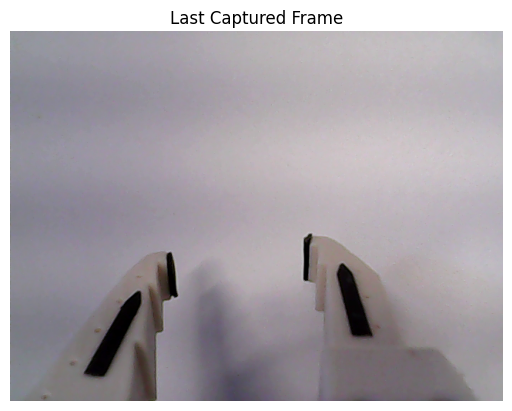

In [13]:
from lerobot.common.cameras.opencv.configuration_opencv import OpenCVCameraConfig
from lerobot.common.cameras.opencv.camera_opencv import OpenCVCamera
from lerobot.common.cameras.configs import ColorMode, Cv2Rotation
import time
import matplotlib.pyplot as plt

# Construct an `OpenCVCameraConfig` with your desired FPS, resolution, color mode, and rotation.
config = OpenCVCameraConfig(
    index_or_path=1,
    fps=27,
    width=640,
    height=480,
    color_mode=ColorMode.RGB,
    rotation=Cv2Rotation.NO_ROTATION
)

# Instantiate and connect an `OpenCVCamera`, performing a warm-up read (default).
camera = OpenCVCamera(config)
camera.connect()

# Read frames asynchronously in a loop via `async_read(timeout_ms)`
try:
    t = time.time()
    for i in range(10):
        frame = camera.async_read(timeout_ms=2000) #NOTE: at least 2 seconds timeout, otherwise it will fail
        print(f"Async frame {i} shape:", frame.shape)
        
        try: 
            print(1/(time.time() - t), 'FPS')
        except ZeroDivisionError:
            pass
        t = time.time()
finally:
    camera.disconnect()

# Display the last captured frame
plt.imshow(frame)
plt.title("Last Captured Frame")
plt.axis('off')
plt.show()

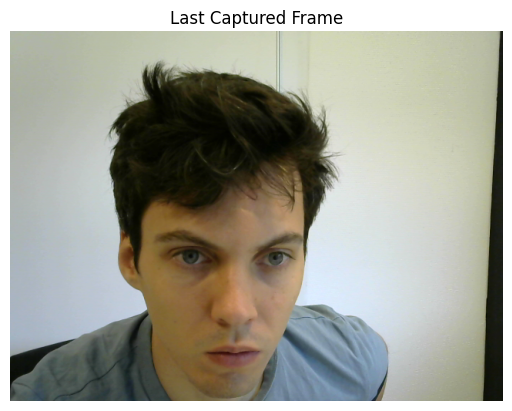

In [2]:
# lessons
- webcam USB on dock will cap at 1 FPS (at least with my dock and everything connected) -> give each camera own port.
- timeout of our USB webcams must be at least 2 seconds.
- @ 1280x720, 7-8 FPS can be reached with USB webcam.
- @ 640x480, 30 FPS can be reached with USB webcam (in 2 of the ports, other port is capped at 15 FPS.)

SyntaxError: invalid decimal literal (2432197884.py, line 4)

In [ ]:
import torch
from torchcodec.codecs import Encodec

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create Encodec model
model = Encodec("encodec_24khz").to(device)
model.eval()

# Dummy audio: batch of 1, 1 channel, 10,000 samples (about 0.4 sec at 24 kHz)
waveform = torch.randn(1, 1, 10000).to(device)

# Forward pass: encode and decode
with torch.no_grad():
    encoded_frames = model.encode(waveform)
    decoded_waveform = model.decode(encoded_frames)

print(f"Original shape: {waveform.shape}")
print(f"Decoded shape: {decoded_waveform.shape}")

c:\ProgramData\miniconda3\envs\lerobot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\miniconda3\envs\lerobot\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jprij\.cache\huggingface\hub\datasets--Unseq--smints1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate deve

Concatenated dataset saved to: smints_combined


In [20]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

def combine_and_push_datasets(hf_user: str, dataset_names: list, split: str = "train", combined_name: str = "combined"):
    assert dataset_names, "You must provide at least one dataset name."
    datasets = [load_dataset(f"{hf_user}/{name}", split=split) for name in dataset_names]
    concatenated = concatenate_datasets(datasets)
    dataset_dict = DatasetDict({split: concatenated})
    repo_name = f"{hf_user}/{combined_name}"
    print(f"Pushing to Hugging Face Hub at: {repo_name}")
    dataset_dict.push_to_hub(repo_name)
    print(f"✅ Upload complete: https://huggingface.co/datasets/{repo_name}")

In [21]:
combine_and_push_datasets('Unseq', ['smints1','smints2'], combined_name='combtest')

Pushing to Hugging Face Hub at: Unseq/combtest


Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


✅ Upload complete: https://huggingface.co/datasets/Unseq/combtest
